# Import JAX

In [1]:
import jax
import haiku as hk
import optax
import numpy as np
import jax.numpy as jnp
from tqdm import tqdm
from functools import partial
from dataclasses import dataclass

# we import some helper function/classes
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from utils import Trainer, params_to_vec, make_forward

import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8

/usr/local/lib/python3.8/dist-packages/chex/_src/pytypes.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))


# Define NN with Dropout

In [2]:
@dataclass
class MLP(hk.Module):
  width : int
  depth : int
      
  def __call__(self, inputs):
    x = inputs
    for i in range(self.depth):
      x = hk.Linear(self.width)(x)
      if i < self.depth-1:
        x = jax.nn.relu(x)
        x = hk.dropout(hk.next_rng_key(), 0.1, x)
    x = hk.Linear(1, name='head')(x)
    return x

# Initialize NN

In [3]:
# define pseudo random number generator for NN initialization
rng = jax.random.PRNGKey(42)
# define artificial input
batch = jnp.zeros((10, 1))

tx = optax.sgd(learning_rate=0.01, momentum=0.9)

mlp = make_forward(partial(MLP, width=100, depth=3))
params_mlp = mlp.init(rng, batch)
trainer = Trainer.create(
    apply_fn=mlp.apply,
    params=params_mlp,
    tx = tx,
)

# Visualize predictions of initialized NNs.

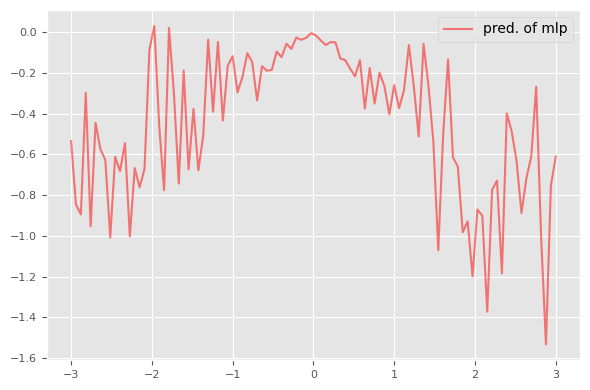

In [4]:
x = jnp.linspace(-3, 3, 100).reshape(-1, 1)

pred = trainer.apply_fn(trainer.params, rng, x)

plt.plot(x.reshape(-1), pred.reshape(-1), label='pred. of mlp', color='red', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

## Note that predictions change according to sampled dropout mask

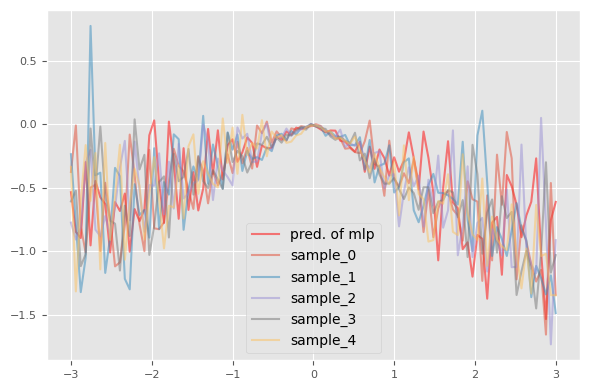

In [5]:
plt.plot(x.reshape(-1), pred.reshape(-1), label='pred. of mlp', color='red', alpha=0.5)

for i in range(5):
    rng, rng_ = jax.random.split(rng)
    pred_ = trainer.apply_fn(trainer.params, rng_, x)
    plt.plot(x.reshape(-1), pred_.reshape(-1), label=f'sample_{i}', alpha=0.5)

plt.legend()
plt.tight_layout()
plt.show()

# Define loss function

In [6]:
# define labels
f = lambda x : jnp.sin(x)
y = f(x)

In [7]:
def loss_fn(params, trainer, inputs, outputs, rng):

  pred = trainer.apply_fn(params, rng, inputs)
  loss = jnp.mean(jnp.sum(jnp.square(pred - outputs),axis=-1))
  weight_decay = jnp.sum(jnp.square(params_to_vec(params)))

  return loss + 5e-4 * weight_decay, (loss, weight_decay)

# Define Optimizer step

In [8]:
def opt_step(trainer, inputs, outputs, rng):

  grad_fn = jax.grad(loss_fn, has_aux=True)
  grads, (loss, wd) = grad_fn(
      trainer.params,
      trainer,
      inputs,
      outputs,
      rng,
  )

  grad_norm = jnp.sqrt(jnp.sum(jnp.square(params_to_vec(grads))))

  trainer = trainer.apply_gradients(grads=grads)

  log = {
      'loss': loss,
      'wd': wd,
      'grad_norm': grad_norm,
  }

  return log, trainer

# Train with data

In [9]:
opt_step_jitted = jax.jit(opt_step)

In [10]:
NUM_STEP = 1000

pbar = tqdm(range(NUM_STEP))
for step in pbar:

  rng, rng_ = jax.random.split(rng)
  log, trainer = opt_step_jitted(trainer, x, y, rng_)

  pbar.set_postfix(log)

100%|██████████| 1000/1000 [00:02<00:00, 434.90it/s, grad_norm=0.57154286, loss=0.03323677, wd=193.61053]


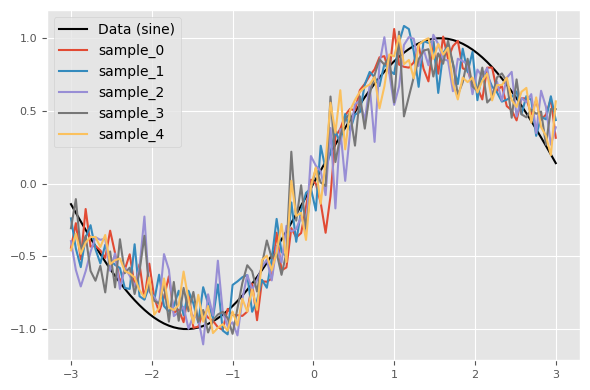

In [11]:
plt.plot(x.reshape(-1), y.reshape(-1), label='Data (sine)', color='black')
for i in range(5):
    rng, rng_ = jax.random.split(rng)
    pred_mlp = trainer.apply_fn(trainer.params, rng_, x)
    plt.plot(x.reshape(-1), pred_mlp.reshape(-1), label=f'sample_{i}')
plt.legend()
plt.tight_layout()
plt.show()